## Visual analysis and Agglomerate clustering

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA as PCA
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('supermarket_customers.csv')

In [5]:
print('shape = ', data.shape)
print(data.columns)

shape =  (200, 5)
Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')


In [16]:
data_model = data.drop(['CustomerID'], axis=1)
data_model['Gender'] = data_model['Gender'].factorize()[0]
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


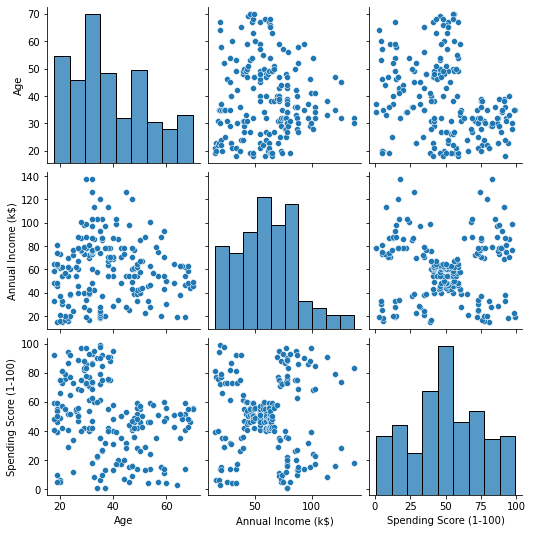

In [9]:
sns.pairplot(data[['Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)']]);

What can we see? Annual Income with Spending Score forms together an interesting picture, look at it later. Age and Annual Income distribution don't seems like normal. They are both shifted to left. Spending Score, at first glance, has too large tails to be normal. But remember, that these conclusions based on histograms, and they can change very high by switch number of bins. So, plot in addition kdeplot from seaborn:

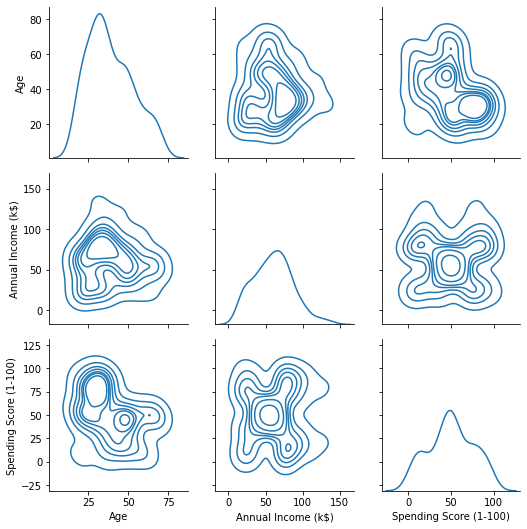

In [13]:
g = sns.PairGrid(data[['Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)']])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=8);

Now analyze cathegorical columns - gender with other features.

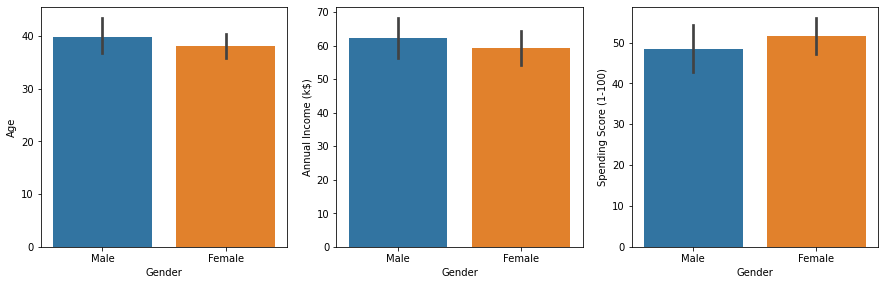

In [14]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(3,3,1)
sns.barplot(y='Age',x='Gender', data=data);
ax2 = fig.add_subplot(3,3,2)
sns.barplot(y='Annual Income (k$)',x='Gender', data=data);
ax3 = fig.add_subplot(3,3,3)
sns.barplot(y='Spending Score (1-100)',x='Gender', data=data);

Good news, gender feature is balace with all another features! It's really interesting. So the model will be more objective. Perhaps, gender feature can be don't useable, but we have so few features. And I can't drop it out of analysis.

Let's start to visualize. Firstly with PCA: 

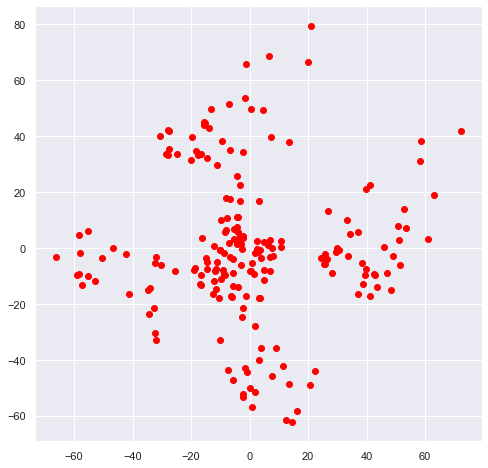

In [18]:
pca = PCA(n_components=2)
pca.fit(data_model)
Xpca = pca.transform(data_model)
sns.set()
plt.figure(figsize=(8,8))
plt.scatter(Xpca[:,0],Xpca[:,1], c='Red')
plt.show()

We can see that algorithm well caught relation between  Annual Income and Spending Score. Before clustering try another interesting method - tsne:

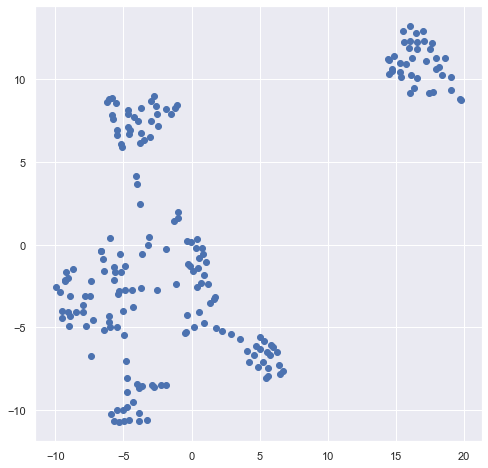

In [19]:
from sklearn.manifold import TSNE
tsn = TSNE()
res_tsne = tsn.fit_transform(data_model)
plt.figure(figsize=(8,8))
plt.scatter(res_tsne[:,0],res_tsne[:,1]);

This method gives us structure with one strongly remote cluster. But now we can't clearly talk how many clusters need model? After PCA - 5 clusters and after tsne? 5 or 6? Apply some cluster methods and find this out. <br>

After PCA we can apply k-means, because groups are roughly homogeneous and uniform. But the same can not be said about tsne data.

In [20]:
from sklearn.cluster import AgglomerativeClustering as AggClus

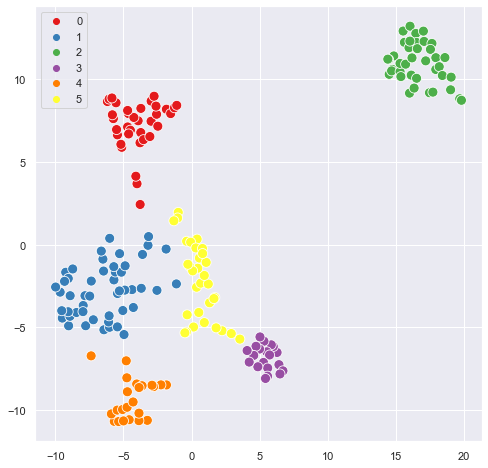

In [21]:
clus_mod = AggClus(n_clusters=6)
assign = clus_mod.fit_predict(data_model)
plt.figure(figsize=(8,8))
sns.set(style='darkgrid',palette='muted')
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=res_tsne[:,0],y=res_tsne[:,1],s=100, hue=assign, palette='Set1');

Is it optimal clusters number? Consider dendrogramm:

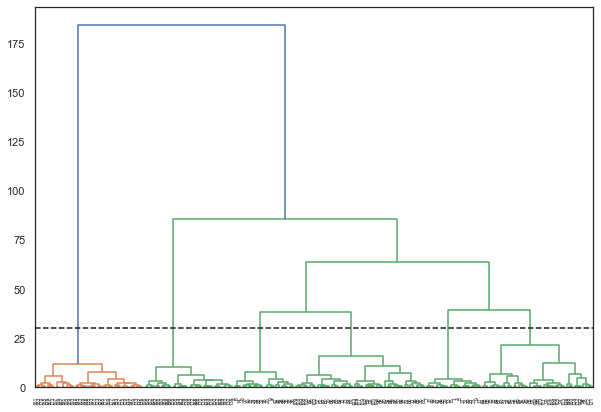

In [22]:
from scipy.cluster.hierarchy import dendrogram, ward
sns.set(style='white')
plt.figure(figsize=(10,7))
link = ward(res_tsne)
dendrogram(link)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [30,30],'--', c='k')
ax.plot(bounds,'--', c='k')
plt.show()

It seems that optimal are 6 clusters. Of course, nothing can be said sure for clustering. You can say that there are 3, 4, 5 or 7 clusters. There is no ready solution, as often happens in data analysis. So, rewrite code:

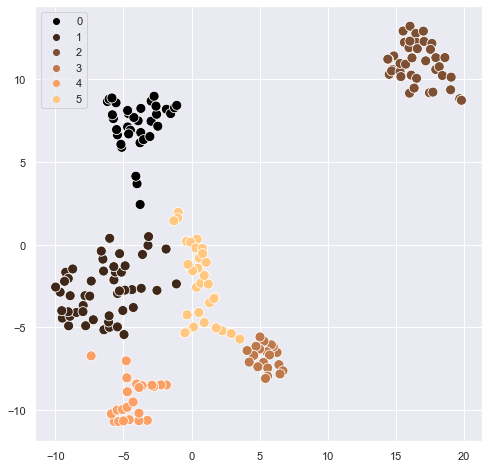

In [23]:
clus_mod = AggClus(n_clusters=6)
assign = clus_mod.fit_predict(data_model)
plt.figure(figsize=(8,8))
sns.set(style='darkgrid',palette='muted')
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=res_tsne[:,0],y=res_tsne[:,1],s=100, hue=assign, palette='copper');

Okay, now I will see what data got into clusters.

In [24]:
data_model['predict'] = pd.DataFrame(assign)

In [25]:
data_model.head(3)

,Gender,Age,Annual Income (k$),Spending Score (1-100),predict
0,0,19,15,39,4
1,0,21,15,81,3
2,1,20,16,6,4


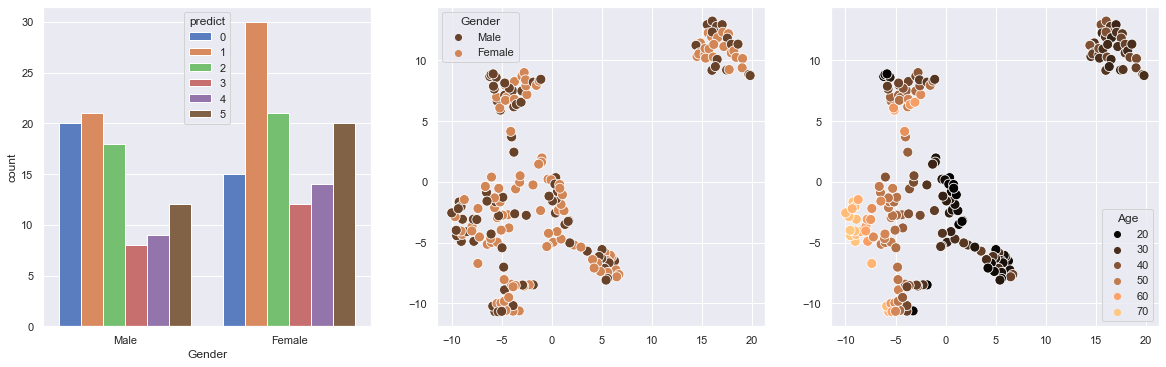

In [26]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(3,3,1)
sns.countplot(data['Gender'],hue=data_model['predict']);
ax2 = fig.add_subplot(3,3,2)
sns.scatterplot(x=res_tsne[:,0],y=res_tsne[:,1],s=100, hue=data['Gender'], palette='copper');
ax3 = fig.add_subplot(3,3,3)
sns.scatterplot(x=res_tsne[:,0],y=res_tsne[:,1],s=100, hue=data['Age'], palette='copper');

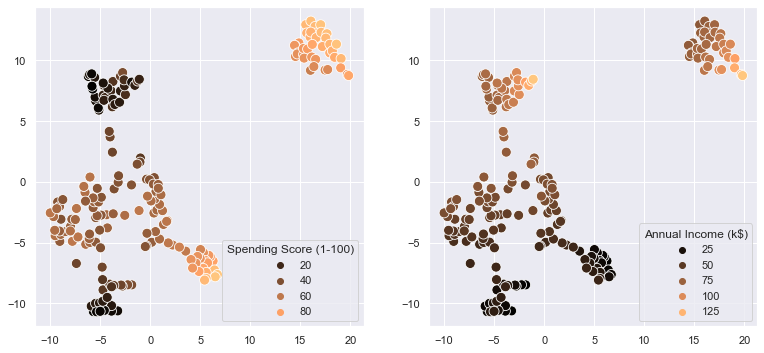

In [27]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(3,3,1)
sns.scatterplot(x=res_tsne[:,0],y=res_tsne[:,1],s=100, hue=data['Spending Score (1-100)'], palette='copper');
ax2 = fig.add_subplot(3,3,2)
sns.scatterplot(x=res_tsne[:,0],y=res_tsne[:,1],s=100, hue=data['Annual Income (k$)'], palette='copper');

Here we can see that except gender (I already mentioned this) other features gives significant results.

In [28]:
model = pd.DataFrame()
model['age'] = data_model['Age'].groupby(data_model['predict']).median()
model['annual income'] = data_model['Annual Income (k$)'].groupby(data_model['predict']).median()
model['spending score'] = data_model['Spending Score (1-100)'].groupby(data_model['predict']).median()
model.reset_index(inplace=True)

In this task we have very rare chance of a two-dimensional data view. We use this to build a silhouette graphics. This graphic show clustering quality.

Text(0.5, 0, 'Silhouette coefficient')

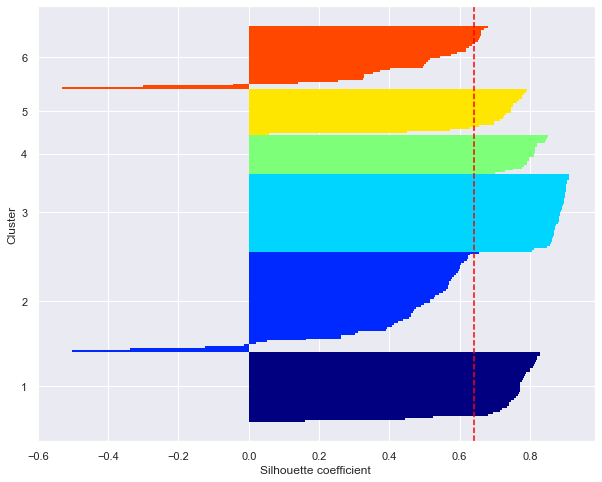

In [29]:
cluster_labels=np.unique(assign)
n_clusters = len(np.unique(assign))
silhouette_vals = silhouette_samples(res_tsne, assign, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
plt.figure(figsize=(10,8))
for i , c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[assign==c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower,y_ax_upper),
                c_silhouette_vals,height=1.0,edgecolor='none',color=color)
        yticks.append((y_ax_lower+y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)

plt.axvline(silhouette_avg,color="red",linestyle= "--")
plt.yticks(yticks , cluster_labels + 1)
plt.ylabel ('Cluster')
plt.xlabel('Silhouette coefficient')

Frankly, this clustering schedule doesn't look perfect. But we can compare it with another variants:

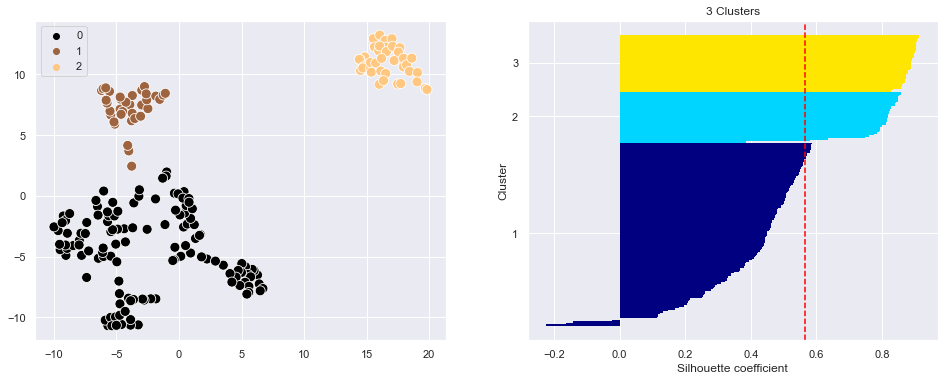

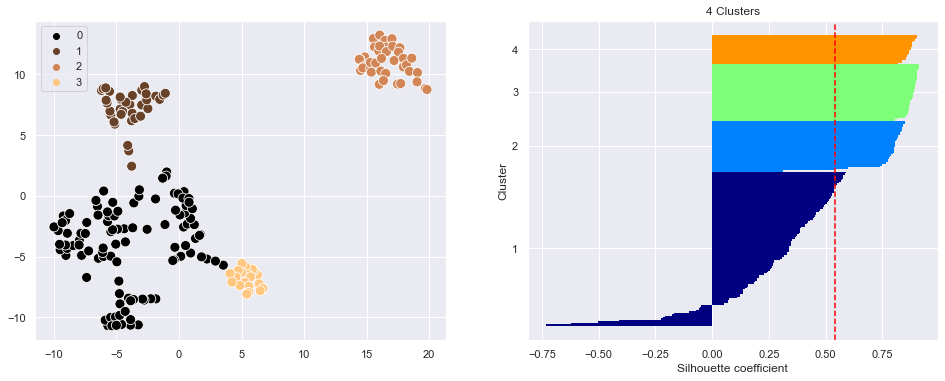

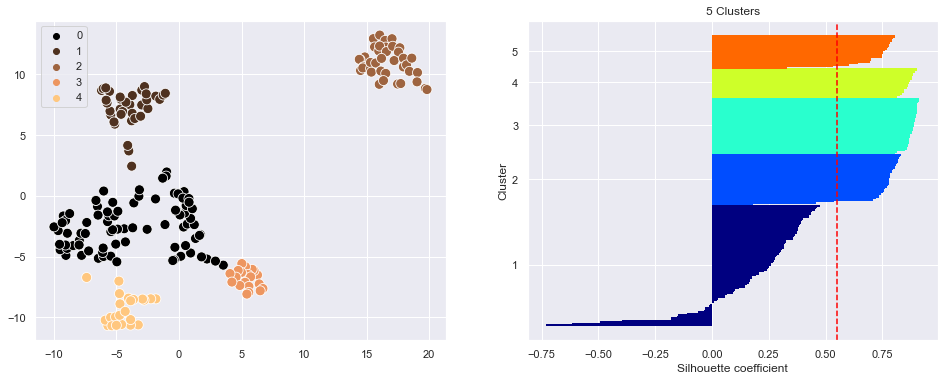

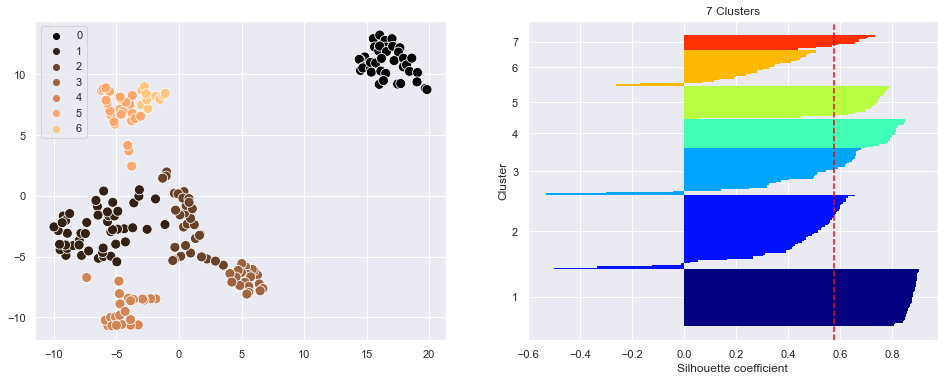

In [30]:
def clust_sill(num):
    fig = plt.figure(figsize=(25,20))
    ax1 = fig.add_subplot(3,3,1)

    clus_mod = AggClus(n_clusters=num)
    assign = clus_mod.fit_predict(data_model)
    sns.set(style='darkgrid',palette='muted')
    cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
    sns.scatterplot(x=res_tsne[:,0],y=res_tsne[:,1],s=100, hue=assign, palette='copper');
    cluster_labels=np.unique(assign)
    n_clusters = len(np.unique(assign))
    silhouette_vals = silhouette_samples(res_tsne, assign, metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    ax2 = fig.add_subplot(3,3,2)
    for i , c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[assign==c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower,y_ax_upper),
                c_silhouette_vals,height=1.0,edgecolor='none',color=color)
        yticks.append((y_ax_lower+y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    
    plt.title(str(num)+ ' Clusters')
    plt.axvline(silhouette_avg,color="red",linestyle= "--")
    plt.yticks(yticks , cluster_labels + 1)
    plt.ylabel ('Cluster')
    plt.xlabel('Silhouette coefficient')
clust_sill(3)
clust_sill(4)
clust_sill(5)
clust_sill(7)

You may notice that my choice of 6 clusters seems optimal in this dataset.

Here you can see characteristics (median) of every cluster:

In [31]:
model

,predict,age,annual income,spending score
0,0,43,85.0,16.0
1,1,50,54.0,49.0
2,2,32,79.0,83.0
3,3,23,23.5,78.0
4,4,46,25.0,17.0
5,5,24,55.5,51.5


Consider clusters distributions. With boxplot graphics we can see that groups are very different.

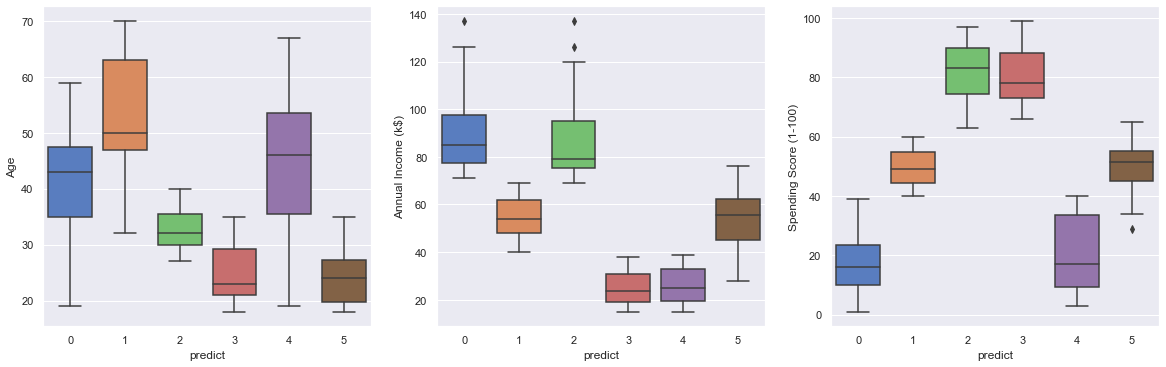

In [32]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(3,3,1)
sns.boxplot(y='Age',x='predict',data=data_model);
ax2 = fig.add_subplot(3,3,2)
sns.boxplot(y='Annual Income (k$)',x='predict',data=data_model);
ax3 = fig.add_subplot(3,3,3)
sns.boxplot(y='Spending Score (1-100)',x='predict',data=data_model);

Thank you for reading! I hope this kernel was helpful for you.